# **TRAFFIC COLLISION PREDICTION - COLLISION**

In [3]:
import pandas as pd
import keras
import tensorflow as tf
from tensorflow.keras import regularizers
from sklearn import preprocessing

**STEP: 1 DATA PREPROCESSING**

In [4]:
#Missing Value in data
df = pd.read_excel(r"C:\Users\farhe\Documents\Learning\Ryerson\Certificate\CIND820\Raw\Data_frame.xlsx", na_values = "Missing",sheet_name='Sheet1')
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27894 entries, 0 to 27893
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   INCIDENT INFO  27894 non-null  object        
 1   DESCRIPTION    27894 non-null  object        
 2   START_DT       27894 non-null  datetime64[ns]
 3   MODIFIED_DT    13837 non-null  datetime64[ns]
 4   QUADRANT       13835 non-null  object        
 5   Longitude      27894 non-null  float64       
 6   Latitude       27894 non-null  float64       
 7   location       27649 non-null  object        
 8   Count          27894 non-null  int64         
 9   id             27894 non-null  object        
 10  Point          27894 non-null  object        
dtypes: datetime64[ns](2), float64(2), int64(1), object(6)
memory usage: 2.3+ MB
None


**STEP 2: EXPLORATORY DATA ANALYSIS**

In [20]:
#Check for data type for each attribute
#df.dtypes
df.info()

#Check min for each attribute
#df.min()

#Check max for each attribute
#df.max()

#Calculate mean for each attribute
#df.mean()

#Calculate standard deviation for each attribute
#df.std()

#Check distinct value for each attribtute
#df.iloc[:,:11].nunique()

#Check missing value for each attribtute
#df.isnull().sum()

#Treat Time in Hours (to identify peak hours of collision) & Days (to identify peak days of collision)
# df['hour'] = df.START_DT.dt.hour
# df['day'] = df.START_DT.dt.day
# df['month'] = df.START_DT.dt.month

#df['hour'].describe()
#df['month'].describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27894 entries, 0 to 27893
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   INCIDENT INFO  27894 non-null  object        
 1   DESCRIPTION    27894 non-null  object        
 2   START_DT       27894 non-null  datetime64[ns]
 3   MODIFIED_DT    13837 non-null  datetime64[ns]
 4   QUADRANT       13835 non-null  object        
 5   Longitude      27894 non-null  float64       
 6   Latitude       27894 non-null  float64       
 7   location       27649 non-null  object        
 8   Count          27894 non-null  int64         
 9   id             27894 non-null  object        
 10  Point          27894 non-null  object        
 11  hour           27894 non-null  int64         
 12  day            27894 non-null  int64         
 13  month          27894 non-null  int64         
dtypes: datetime64[ns](2), float64(2), int64(4), object(6)
memory usage: 3.

**Box Plots**

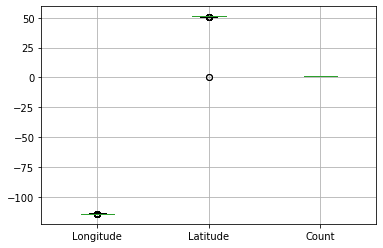

In [4]:
#Identify outliers for numerical columns
df.boxplot(column=['Longitude', 'Latitude', 'Count'])

**Histogram**

(0.0, 2930.0)

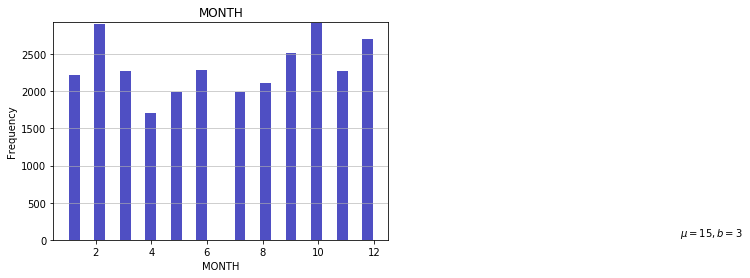

In [5]:
#MOST INCIDENTS OCCUR IN OCTOBER AND FEBRUARY
import matplotlib.pyplot as plt
import numpy as np

n, bins, patches = plt.hist(x=df.iloc[:,13], bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('MONTH')
plt.ylabel('Frequency')
plt.title('MONTH')
plt.text(23, 45, r'$\mu=15, b=3$')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

(0.0, 2630.0)

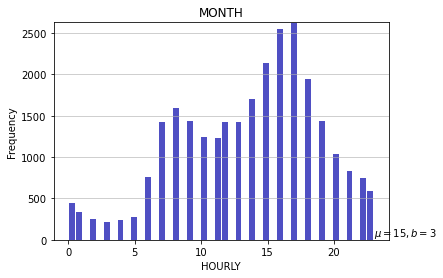

In [24]:
#MOST INCIDENTS OCCUR BETWEEN RUSH HOUR TIME ESPECIALLY BETWEEN 3PM AND 6PM
import matplotlib.pyplot as plt
import numpy as np

n, bins, patches = plt.hist(x=df.iloc[:,11], bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('HOURLY')
plt.ylabel('Frequency')
plt.title('MONTH')
plt.text(23, 45, r'$\mu=15, b=3$')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

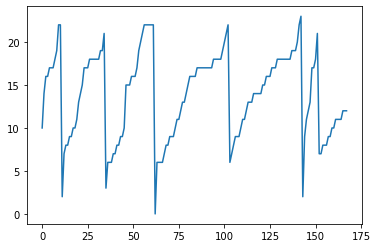

In [8]:
#Hourly data shows cyclical trend best represented as line graph
sample = df[:168] # roughly the first week of the data
ax = sample['hour'].plot()


**Correlation**

In [7]:
df.corr()

,Longitude,Latitude,Count,hour,day,month
Longitude,1.000000,-0.023498,NaN,-0.009789,0.003469,0.018018
Latitude,-0.023498,1.000000,NaN,0.003337,-0.010856,-0.007313
Count,NaN,NaN,NaN,NaN,NaN,NaN
hour,-0.009789,0.003337,NaN,1.000000,0.012672,0.032510
day,0.003469,-0.010856,NaN,0.012672,1.000000,0.038882
month,0.018018,-0.007313,NaN,0.032510,0.038882,1.000000


**Clustering (DBSCAN)**

In [11]:
#To ensure geopy is installed for location data
#!pip install geopy

#To ensure shapely is installed for location data
#!pip install shapely

In [5]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, time
from sklearn.cluster import DBSCAN
from sklearn import metrics
import geopy
from geopy.distance import great_circle
from shapely.geometry import MultiPoint
%matplotlib inline

In [6]:
# define the number of kilometers in one radian
kms_per_radian = 6371.0088

In [7]:
# represent points consistently as (lat, lon) and force as type float
coords2 = df.values[:,5:7] 
your_array = coords2.astype(float)
coords = np.exp(your_array)

# define epsilon as 1.5 kilometers, converted to radians for use by haversine
epsilon = 1.5 / kms_per_radian

In [8]:
start_time = time.time()
db = DBSCAN(eps=epsilon, min_samples=1, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
cluster_labels = db.labels_

# get the number of clusters
num_clusters = len(set(cluster_labels))

# all done, print the outcome
message = 'Clustered {:,} points down to {:,} clusters, for {:.1f}% compression in {:,.2f} seconds'
print(message.format(len(df), num_clusters, 100*(1 - float(num_clusters) / len(df)), time.time()-start_time))
print('Silhouette coefficient: {:0.03f}'.format(metrics.silhouette_score(coords, cluster_labels)))

Clustered 27,894 points down to 8,616 clusters, for 69.1% compression in 58.24 seconds
Silhouette coefficient: -0.564


In [11]:
# turn the clusters in to a pandas series, where each element is a cluster of points
clusters = pd.Series([coords[cluster_labels==n] for n in range(num_clusters)])

In [12]:
def get_centermost_point(cluster):
    centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
    centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
    return tuple(centermost_point)

centermost_points = clusters.map(get_centermost_point)
centermost_points  #8616 clusters

0       (3.0364228819588115e-50, 1.4213234539070235e+22)
1       (2.9061119381350124e-50, 1.5741079331154237e+22)
2       (2.8013370877041646e-50, 1.2818361058248412e+22)
3        (3.008261493038511e-50, 1.4177430648902356e+22)
4        (3.312801570837565e-50, 1.5796717294264374e+22)
                              ...                       
8611     (2.7160781967343332e-50, 1.663053088045348e+22)
8612     (2.786818256379497e-50, 1.4055330814143484e+22)
8613     (2.907419532642269e-50, 1.4009189269777326e+22)
8614     (3.053194464776626e-50, 1.5067517649166438e+22)
8615    (2.7490531342773473e-50, 1.6711749579150396e+22)
Length: 8616, dtype: object

In [13]:
# unzip the list of centermost points (lat, lon) tuples into separate lat and lon lists
lats, lons = zip(*centermost_points)

# from these lats/lons create a new df of one representative point for each cluster
rep_points = pd.DataFrame({'Longitude':lons, 'Latitude':lats})
rep_points.tail()

,Longitude,Latitude
8611,1.663053e+22,2.716078e-50
8612,1.405533e+22,2.786818e-50
8613,1.400919e+22,2.907420e-50
8614,1.506752e+22,3.053194e-50
8615,1.671175e+22,2.749053e-50


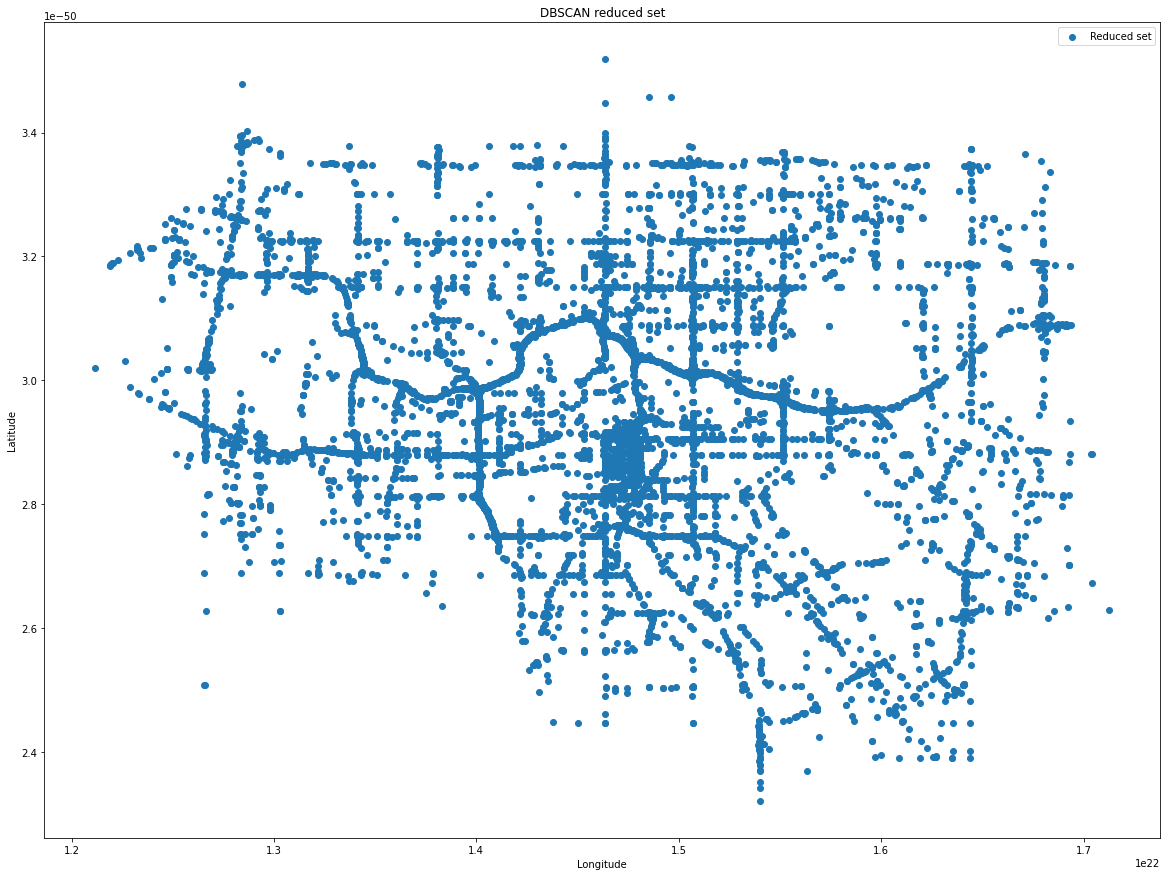

In [14]:
# plot the final reduced set of coordinate points vs the original full set
fig, ax = plt.subplots(figsize=[20, 15])
#rs_scatter = ax.scatter(rep_points['Longitude'], rep_points['Latitude'], c='#99cc99', edgecolor='None', alpha=0.7, s=120)
#df_scatter = ax.scatter(df['Longitude'], df['Latitude'], c='k', alpha=0.9, s=3)

rs_scatter = ax.scatter(rep_points['Longitude'], rep_points['Latitude'])
#df_scatter = ax.scatter(df['Longitude'], df['Latitude'])


ax.set_title('DBSCAN reduced set')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
#ax.legend([df_scatter, rs_scatter], ['Full set', 'Reduced set'], loc='upper right')
ax.legend([rs_scatter], ['Reduced set'], loc='upper right')
plt.show()

**STEP 3: Feature Engineering**

In [30]:
#We start seperating the class attribute which is the column DESCRIPTION
df['DESCRIPTION'].value_counts()

Two vehicle incident.                                                                                             7580
Traffic incident.                                                                                                 3298
Single vehicle incident.                                                                                          2290
Multi-vehicle incident.                                                                                           1386
Two vehicle incident. Blocking the right lane                                                                      749
                                                                                                                  ... 
The rail arm is stuck in the down position, the road is blocked in both directions. Crews have been dispatched       1
Two vehicle incident. Blocking the EB lanes and NB to WB left lanes                                                  1
Single vehicle incident. One left lane open.    

In [21]:
#We identify the top 4 classes as either 'Two vehicle incident', 'Single vehicle incident','Multi-vehicle incident' 
#or just 'Traffic Incident'. We then isolate them as seperate data frames

class_1=df[(df['DESCRIPTION']=='Two vehicle incident.')].reset_index(drop=True)
class_1=class_1.head(1386)
class_1['output_class']=1


class_2=df[(df['DESCRIPTION']=='Traffic incident.')].reset_index(drop=True)
class_2=class_2.head(1386)
class_2['output_class']=2

class_3=df[(df['DESCRIPTION']=='Single vehicle incident.')].reset_index(drop=True)
class_3=class_3.head(1386)
class_3['output_class']=3

class_4=df[(df['DESCRIPTION']=='Multi-vehicle incident.')].reset_index(drop=True)
class_4=class_4.head(1386)
class_4['output_class']=4

**FEATURE SELECTION**

In [22]:
#Concatenate all the new indexed data frames together which also eliminates noise from the original data set that we saw from clustering
classes=pd.concat([class_1, class_2, class_3, class_4], ignore_index=True)
#classes.info()
classes.head()

,INCIDENT INFO,DESCRIPTION,START_DT,MODIFIED_DT,QUADRANT,Longitude,Latitude,location,Count,id,Point,hour,day,month,output_class
0,Barlow Trail at 114 Avenue SE,Two vehicle incident.,2017-02-10 05:25:37,2017-02-10 05:26:39,SE,-113.982111,50.950529,"(50.950529480111, -113.982110792952)",1,2017-02-10T05:25:3750.950529480111-113.9821107...,POINT (-113.982110792952 50.950529480111),5,10,2,1
1,7 Avenue at 8 Street SW,Two vehicle incident.,2017-02-24 21:17:21,2017-02-24 21:18:17,SW,-114.081184,51.047030,"(51.047030227695, -114.081184066899)",1,2017-02-24T21:17:2151.0470302276954-114.081184...,POINT (-114.081184066899 51.0470302276954),21,24,2,1
2,Memorial Drive at 52 Street NE,Two vehicle incident.,2017-04-13 13:18:14,2017-04-13 13:22:23,NE,-113.956440,51.053285,"(51.053284949249, -113.956439737746)",1,2017-04-13T12:18:1451.0532849492493-113.956439...,POINT (-113.956439737746 51.0532849492493),13,13,4,1
3,Country Hills Boulevard at Metis Trail NE,Two vehicle incident.,2017-04-13 19:22:42,2017-04-13 19:25:34,NE,-113.971462,51.154218,"(51.154218001002, -113.971461619051)",1,2017-04-13T18:22:4251.1542180010021-113.971461...,POINT (-113.971461619051 51.1542180010021),19,13,4,1
4,23 Avenue and 32 Street NE,Two vehicle incident.,2017-04-14 01:36:20,2017-04-14 01:40:51,NE,-113.988688,51.072753,"(51.072752532689, -113.988688490482)",1,2017-04-14T00:36:2051.0727525326891-113.988688...,POINT (-113.988688490482 51.0727525326891),1,14,4,1


In [34]:
#We had already split START_DT into hour, day, month for EDA and added it to our dataframe.
#This is now our feature selection as well

In [23]:
#We have shortlisted our input features to 1.Longitude 2.Latitude 3.hour 4.day 5.month 
#Our output is output_class
# We can now set up our model with a clean dataframe that only contains our ML features

df_ML=classes.iloc[:,5:7]
df_ML['hour']=classes.iloc[:,11]
df_ML['day']=classes.iloc[:,12]
df_ML['month']=classes.iloc[:,13]
df_ML['output_class']=classes.iloc[:,14]

df_ML.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5544 entries, 0 to 5543
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Longitude     5544 non-null   float64
 1   Latitude      5544 non-null   float64
 2   hour          5544 non-null   int64  
 3   day           5544 non-null   int64  
 4   month         5544 non-null   int64  
 5   output_class  5544 non-null   int64  
dtypes: float64(2), int64(4)
memory usage: 260.0 KB


**Step 4: Set Up ML model**

#### One-hot encoding the output

In [24]:
one_hot=pd.get_dummies(df_ML['output_class'])
one_hot=one_hot.rename(columns={1:'Two vehicle incident.',
                                2: 'Traffic incident.',
                                3: 'Single vehicle incident.',
                                4: 'Multi-vehicle incident.'})
df_ML=pd.concat([df_ML, one_hot], axis=1)
df_ML=df_ML.drop('output_class', axis=1)

#### Randomly shuffling the dataset

In [25]:
df_ML=df_ML.sample(frac=1, random_state=7).reset_index(drop=True)

In [26]:
# Selecting the Input Class
x=df_ML[df_ML.columns[:5]]

In [27]:
# Selecting the Output Class
y=df_ML[df_ML.columns[-4:]]

In [29]:
!pip install numpy

#### K-Fold Cross Validation

(Stratified) K-Fold Validation is used to estimate the unbiased accuracy of the Neural Network Model

In [30]:
import numpy
inputs=x.to_numpy()
outputs=y.to_numpy()

ground_truth=[]
for ix, values in enumerate(outputs):
    for ix2, values2 in enumerate(values):
        if values2 == 1:
            ground_truth.append(ix2)
            
output_labels=numpy.array(ground_truth)

In [32]:
from sklearn.model_selection import StratifiedKFold

train_index=[]
test_index=[]
K=10

skf = StratifiedKFold(n_splits=K, shuffle=True, random_state=42)
for train, test in skf.split(inputs, output_labels):
    print('train - {} │ test - {}'.format(np.bincount(output_labels[train]), np.bincount(output_labels[test])))
    train_index.append(train)
    test_index.append(test)

train - [1247 1247 1247 1248] │ test - [139 139 139 138]
train - [1247 1247 1247 1248] │ test - [139 139 139 138]
train - [1247 1247 1248 1247] │ test - [139 139 138 139]
train - [1247 1247 1248 1247] │ test - [139 139 138 139]
train - [1247 1248 1248 1247] │ test - [139 138 138 139]
train - [1247 1248 1248 1247] │ test - [139 138 138 139]
train - [1248 1248 1247 1247] │ test - [138 138 139 139]
train - [1248 1248 1247 1247] │ test - [138 138 139 139]
train - [1248 1247 1247 1248] │ test - [138 139 139 138]
train - [1248 1247 1247 1248] │ test - [138 139 139 138]


In [52]:
def evaluate_model(trainX, trainY, testX, testY):
    '''
    The function that is used to evaluate a single iteration 
    of the model during the K-fold validation algorithm
    
    Parameters:
    -----------
        - trainX: the training data (inputs)
        - trainY: the training data (outputs)
        - testX: the test data (inputs)
        - testY: the test data (outputs)
    
    Returns:
    --------
        - model: the trained neural network model
        - test_acc: the accuracy of the test dataset
    '''
    
    # defining the model
    model=keras.Sequential()
    model.add(keras.layers.Dense(400, input_dim=5, kernel_regularizer=regularizers.l2(0.0001), activation='relu'))
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Dense(128, kernel_regularizer=regularizers.l2(0.0001), activation='relu'))
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Dense(32, kernel_regularizer=regularizers.l2(0.0001), activation='relu'))
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Dense(4, activation='softmax'))
    
    
    # Compiling the model
    model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
    
    
    # fitting the model
    DNN=model.fit(preprocessing.scale(trainX), 
                   trainY, 
                   epochs=50, 
                   batch_size=32, 
                   verbose=1, 
                   validation_data=(preprocessing.scale(testX), testY))
    
    # evaluating the model
    results = model.evaluate(preprocessing.scale(testX), testY, verbose=0)
    test_acc=results[1]
    
    return DNN, model, test_acc
    
    
    
    

In [53]:
Acc_Scores=[]
models=[]
DNN_resuts=[]
for loop in range (1):
    dnn, mod, acc = evaluate_model(inputs[train_index[loop]], outputs[train_index[loop]], inputs[test_index[loop]], outputs[test_index[loop]])
    Acc_Scores.append(acc)
    models.append(mod)
    DNN_resuts.append(dnn)

Epoch 1/50
156/156 [==============================] - 2s 5ms/step - loss: 1.3726 - accuracy: 0.3237 - val_loss: 1.3340 - val_accuracy: 0.3568
Epoch 2/50
156/156 [==============================] - 1s 6ms/step - loss: 1.3194 - accuracy: 0.3630 - val_loss: 1.3153 - val_accuracy: 0.3640
Epoch 3/50
156/156 [==============================] - 1s 6ms/step - loss: 1.2991 - accuracy: 0.3842 - val_loss: 1.3003 - val_accuracy: 0.3658
Epoch 4/50
156/156 [==============================] - 1s 6ms/step - loss: 1.2822 - accuracy: 0.3838 - val_loss: 1.3098 - val_accuracy: 0.3658
Epoch 5/50
156/156 [==============================] - 1s 4ms/step - loss: 1.2707 - accuracy: 0.3949 - val_loss: 1.2826 - val_accuracy: 0.3694
Epoch 6/50
156/156 [==============================] - 1s 5ms/step - loss: 1.2549 - accuracy: 0.4105 - val_loss: 1.2733 - val_accuracy: 0.3874
Epoch 7/50
156/156 [==============================] - 1s 6ms/step - loss: 1.2526 - accuracy: 0.4079 - val_loss: 1.2816 - val_accuracy: 0.3730
Epoch 

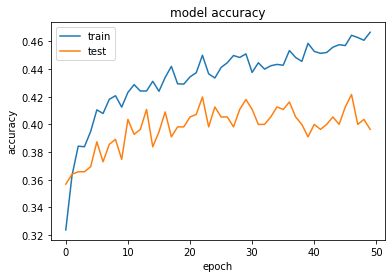

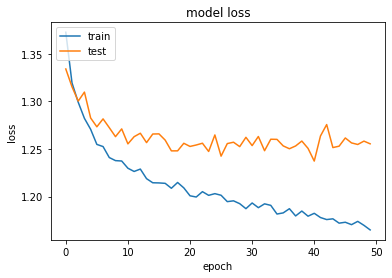

In [54]:
#from keras.callbacks import History 

# summarize history for accuracy
plt.plot(dnn.history['accuracy'])
plt.plot(dnn.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(dnn.history['loss'])
plt.plot(dnn.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**Step 5: Confusion Matrix**

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(trainY, testY)